# Run Different Optimization Scenarios in the TSA 24 ws3 model

Optionally, uninstall the ws3 package and replace it with a pointer to this local clone of the GitHub repository code (useful if you want ot tweak the source code for whatever reason).

## Set up modelling environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ws3
ws3.__path__

['/media/data/project/yyan/ws3_model/tsa24/ws3']

In [3]:
# install_ws3 = True
# install_ws3_localeditable = None
# if install_ws3:
#     if install_ws3_localeditable: # clobber ws3 installation with local editable copy
#         %pip uninstall -y ws3
#         %pip install -e ..
#     else: # install dev_libcbm branch from ws3 GitHub repo
#         %pip install -U git+https://github.com/gparadis/ws3@dev_libcbm
#     import ws3
#     ws3.__path__

In [4]:
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

## Create and run `ForestModel` instance

In [5]:
%pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import time
Start = time.time()

In [7]:
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [8]:
fm = ws3.forest.ForestModel(model_name='tsa24',
                            model_path='data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [9]:
from util import compile_scenario, plot_scenario

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total net Emission (tons)'}>],
       dtype=object))

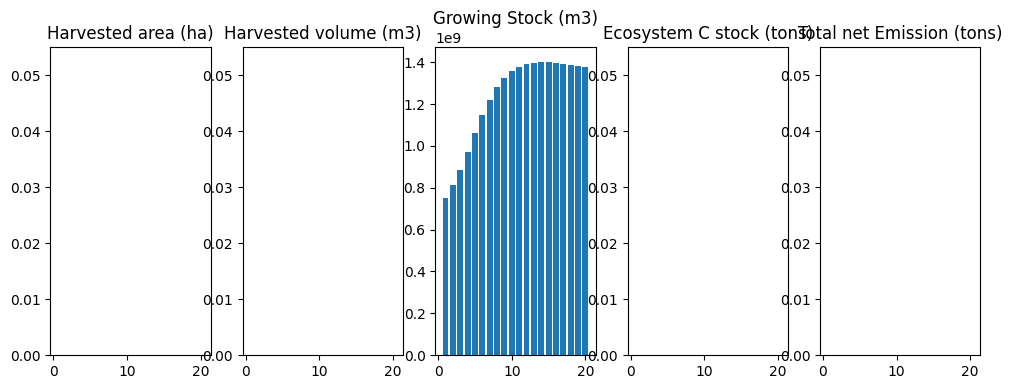

In [10]:
df = compile_scenario(fm)
plot_scenario(df)

## Hard-link `ForestModel` to `libcbm`

In [11]:
import libcbm
from util import run_cbm, cbm_report, plugin_c_curves, compare_ws3_cbm

Prepare CBM input files

In [12]:
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]

In [13]:
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [14]:
sit_config = {
                'mapping_config': {
                    'nonforest': None,
                    'species': {
                        'species_classifier': 'species',
                        'species_mapping': [
                            {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                            {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
                        ]
                    },
                    'spatial_units': {
                        'mapping_mode': 'SingleDefaultSpatialUnit',
                        'admin_boundary': 'British Columbia',
                        'eco_boundary': 'Montane Cordillera'},
                    'disturbance_types': {
                        'disturbance_type_mapping': disturbance_type_mapping
                    }
                }
            }

In [15]:
sit_classifiers = pd.read_csv('data/libcbm_model_files/sit_classifiers.csv')
sit_disturbance_types = pd.read_csv('data/libcbm_model_files/sit_disturbance_types.csv')
sit_age_classes = pd.read_csv('data/libcbm_model_files/sit_age_classes.csv')
sit_inventory = pd.read_csv('data/libcbm_model_files/sit_inventory.csv')
sit_yield = pd.read_csv('data/libcbm_model_files/sit_yield.csv')
sit_events = pd.read_csv('data/libcbm_model_files/sit_events.csv')
# sit_events = fm._cbm_sit_events()
sit_transitions = pd.read_csv('data/libcbm_model_files/sit_transitions.csv')

In [16]:
sit_tables = {'sit_classifiers': sit_classifiers,
              'sit_disturbance_types': sit_disturbance_types,
              'sit_age_classes': sit_age_classes,
              'sit_inventory': sit_inventory,
              'sit_yield': sit_yield,
              'sit_events': sit_events,
              'sit_transitions': sit_transitions}

In [17]:
# self = fm
# sit_tables = {'sit_classifiers':self._cbm_sit_classifiers(),
#               'sit_disturbance_types':self._cbm_sit_disturbance_types(),
#               'sit_age_classes':self._cbm_sit_age_classes(),
#               'sit_inventory':self._cbm_sit_inventory(softwood_volume_yname='swdvol', 
#                                                       hardwood_volume_yname='hwdvol'),
#               'sit_yield':self._cbm_sit_yield(softwood_volume_yname='swdvol', 
#                                               hardwood_volume_yname='hwdvol', n_yield_vals=100),
#               'sit_events':self._cbm_sit_events(),
#               'sit_transitions':self._cbm_sit_transitions()}

In [18]:
# sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
#                                        hardwood_volume_yname='hwdvol', 
#                                        admin_boundary='British Columbia', 
#                                        eco_boundary='Montane Cordillera',
#                                        disturbance_type_mapping=disturbance_type_mapping)

In [19]:
n_steps = fm.horizon * fm.period_length
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

Define carbon pools

In [20]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

Define carbon fluxes

In [21]:
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

In [22]:
pools = ecosystem_pools
fluxes = all_fluxes

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['all_fluxes']

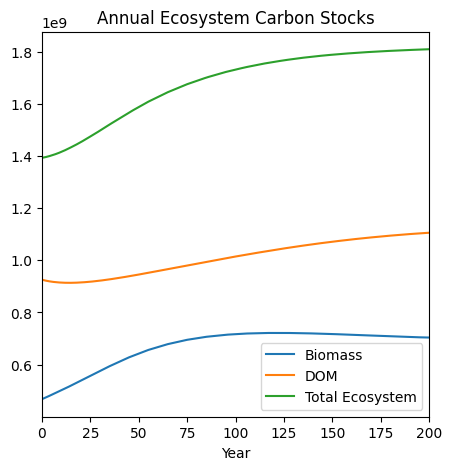

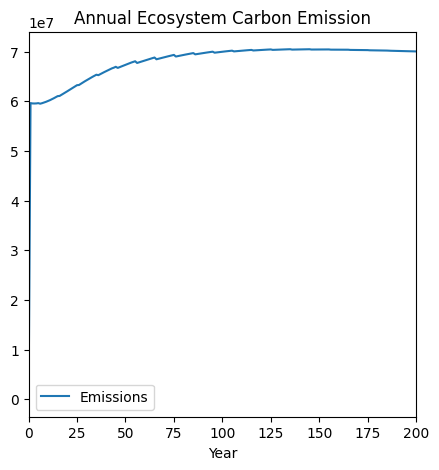

In [23]:
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

## Generate and Add Carbon Yield Curves

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [24]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [25]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,0,2401000,100,2401000,softwood,False,5,345.7,0,0,fire,fire
1,tsa24,0,2401000,100,2401000,softwood,False,15,825.8,0,0,fire,fire
2,tsa24,0,2401000,100,2401000,softwood,False,25,1611.1,0,0,fire,fire
3,tsa24,0,2401000,100,2401000,softwood,False,35,1508.5,0,0,fire,fire
4,tsa24,0,2401000,100,2401000,softwood,False,45,264.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,tsa24,1,2403007,100,2423007,softwood,False,25,7712.3,0,0,fire,harvest
766,tsa24,1,2403007,100,2423007,softwood,False,35,15703.9,0,0,fire,harvest
767,tsa24,1,2403007,100,2423007,softwood,False,45,11587.8,0,0,fire,harvest
768,tsa24,1,2403007,100,2423007,softwood,False,55,6871.6,0,0,fire,harvest


In [26]:
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 0)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [27]:
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,0,2401000,100,2401000,softwood,False,0,1.0,0,0,fire,fire
1,tsa24,0,2401001,304,2401001,softwood,False,0,1.0,0,0,fire,fire
2,tsa24,0,2401003,304,2401003,softwood,False,0,1.0,0,0,fire,fire
3,tsa24,0,2401004,104,2401004,softwood,False,0,1.0,0,0,fire,fire
4,tsa24,0,2401005,1201,2401005,hardwood,False,0,1.0,0,0,fire,fire
5,tsa24,0,2401006,1201,2401006,hardwood,False,0,1.0,0,0,fire,fire
6,tsa24,0,2402001,304,2402001,softwood,False,0,1.0,0,0,fire,fire
7,tsa24,0,2402005,1201,2402005,hardwood,False,0,1.0,0,0,fire,fire
8,tsa24,0,2402006,1201,2402006,hardwood,False,0,1.0,0,0,fire,fire
9,tsa24,0,2403005,1201,2403005,hardwood,False,0,1.0,0,0,fire,fire


In [28]:
df_sub = df.loc[(df['theme1'] == 1) & (df['last_pass_disturbance'] == 'fire')]
df_sub['theme4'] = df_sub['theme4'].apply(lambda x: x + 20000)
df_sub['last_pass_disturbance'] = df_sub['last_pass_disturbance'].apply(lambda x: 'harvest')

/tmp/ipykernel_33269/1329267401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['theme4'] = df_sub['theme4'].apply(lambda x: x + 20000)
/tmp/ipykernel_33269/1329267401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['last_pass_disturbance'] = df_sub['last_pass_disturbance'].apply(lambda x: 'harvest')


In [29]:
df_sub

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
11,tsa24,1,2401002,204,2421002,softwood,False,0,1.0,0,0,fire,harvest
13,tsa24,1,2401007,100,2421007,softwood,False,0,1.0,0,0,fire,harvest
15,tsa24,1,2402000,100,2422000,softwood,False,0,1.0,0,0,fire,harvest
17,tsa24,1,2402002,204,2422002,softwood,False,0,1.0,0,0,fire,harvest
19,tsa24,1,2402003,304,2422003,softwood,False,0,1.0,0,0,fire,harvest
21,tsa24,1,2402004,104,2422004,softwood,False,0,1.0,0,0,fire,harvest
23,tsa24,1,2402007,100,2422007,softwood,False,0,1.0,0,0,fire,harvest
25,tsa24,1,2403000,100,2423000,softwood,False,0,1.0,0,0,fire,harvest
27,tsa24,1,2403001,304,2423001,softwood,False,0,1.0,0,0,fire,harvest
29,tsa24,1,2403002,204,2423002,softwood,False,0,1.0,0,0,fire,harvest


In [30]:
df = pd.concat([df, df_sub], ignore_index=True)

In [31]:
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,0,2401000,100,2401000,softwood,False,0,1.0,0,0,fire,fire
1,tsa24,0,2401001,304,2401001,softwood,False,0,1.0,0,0,fire,fire
2,tsa24,0,2401003,304,2401003,softwood,False,0,1.0,0,0,fire,fire
3,tsa24,0,2401004,104,2401004,softwood,False,0,1.0,0,0,fire,fire
4,tsa24,0,2401005,1201,2401005,hardwood,False,0,1.0,0,0,fire,fire
5,tsa24,0,2401006,1201,2401006,hardwood,False,0,1.0,0,0,fire,fire
6,tsa24,0,2402001,304,2402001,softwood,False,0,1.0,0,0,fire,fire
7,tsa24,0,2402005,1201,2402005,hardwood,False,0,1.0,0,0,fire,fire
8,tsa24,0,2402006,1201,2402006,hardwood,False,0,1.0,0,0,fire,fire
9,tsa24,0,2403005,1201,2403005,hardwood,False,0,1.0,0,0,fire,fire


In [32]:
sit_tables['sit_inventory'] = df

In [33]:
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [34]:
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [35]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,Input,SoftwoodMerch,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa24,0,2401000,100,2401000,softwood,1.0,0.000000,...,74.016010,52.671391,23.112688,0.000000,0.000000,5878.431742,6.068142,54.611643,0.0,0.000000
1,2,0,tsa24,0,2401001,304,2401001,softwood,1.0,0.000000,...,44.921289,27.501144,19.287436,0.000000,0.000000,3613.528216,4.476831,40.290231,0.0,0.000000
2,3,0,tsa24,0,2401003,304,2401003,softwood,1.0,0.000000,...,70.049220,62.438897,24.551759,0.000000,0.000000,5650.351208,6.311380,56.800795,0.0,0.000000
3,4,0,tsa24,0,2401004,104,2401004,softwood,1.0,0.000000,...,53.956053,44.779207,21.934440,0.000000,0.000000,4365.512943,5.270469,47.432810,0.0,0.000000
4,5,0,tsa24,0,2401005,1201,2401005,hardwood,1.0,0.000000,...,127.289305,0.000000,0.000000,102.657634,21.803018,10841.470933,9.787445,88.084688,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,46,200,tsa24,1,2403001,304,2423001,softwood,1.0,63.042997,...,62.653682,5.887827,1.913895,0.000000,0.000000,4721.384475,4.902757,44.123526,0.0,40.018378
10046,47,200,tsa24,1,2403002,204,2423002,softwood,1.0,93.878994,...,109.359666,10.289182,2.294782,0.000000,0.000000,8613.499612,7.597707,68.377586,0.0,79.633546
10047,48,200,tsa24,1,2403003,304,2423003,softwood,1.0,95.609403,...,94.058717,9.559927,2.290215,0.000000,0.000000,7339.963239,6.855230,61.695426,0.0,72.563607
10048,49,200,tsa24,1,2403004,104,2423004,softwood,1.0,75.781025,...,74.672467,7.263171,2.059984,0.000000,0.000000,5721.036242,5.630286,50.671138,0.0,51.700860


In [36]:
fi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,DisturbanceCO2Production,DisturbanceCH4Production,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,tsa24,0,2401000,100,2401000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,tsa24,0,2401001,304,2401001,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,tsa24,0,2401003,304,2401003,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,tsa24,0,2401004,104,2401004,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,tsa24,0,2401005,1201,2401005,hardwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,46,200,tsa24,1,2403001,304,2423001,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10046,47,200,tsa24,1,2403002,204,2423002,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10047,48,200,tsa24,1,2403003,304,2423003,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10048,49,200,tsa24,1,2403004,104,2423004,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)

In [38]:
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

Create Summany Carbon Indicators Curves

In [39]:
# Sum carbon pools
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

# Sum carbon fluxes
c_curves_f['all_fluxes'] = c_curves_f[all_fluxes].sum(axis=1)

In [40]:
# Just include the sum carbon curves
c_curves_p = c_curves_p.iloc[:, -3:]
c_curves_f = c_curves_f.iloc[:, -1:]

In [41]:
c_curves_p

ecosystem     biomass         DOM
dtype_key                   timestep                                    
tsa24 0 2401000 100 2401000 0         197.315308    0.000000  197.315308
                            1         193.354830    0.173733  193.181097
                            2         189.858401    0.501566  189.356836
                            3         186.734062    0.930634  185.803428
                            4         183.927586    1.440346  182.487240
...                                          ...         ...         ...
tsa24 1 2403007 100 2423007 196       821.799994  378.691984  443.108010
                            197       822.596508  378.913000  443.683508
                            198       823.389431  379.133996  444.255434
                            199       824.178884  379.354974  444.823910
                            200       824.964979  379.575934  445.389045

[7437 rows x 3 columns]

In [42]:
c_curves_f

all_fluxes
dtype_key                   timestep            
tsa24 0 2401000 100 2401000 0           0.000000
                            1           8.476899
                            2           8.110240
                            3           7.803448
                            4           7.556691
...                                          ...
tsa24 1 2403007 100 2423007 196        30.125396
                            197        30.145813
                            198        30.165963
                            199        30.185870
                            200        30.205556

[7437 rows x 1 columns]

In [43]:
# c_curves_f.to_csv('data/c_curves/curves_fluxes.csv', index=False)

In [44]:
plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=sum_fluxes)

found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402006', '?', '2402006

Get back the orginial inventory table

In [45]:
sit_inventory = pd.read_csv('data/libcbm_model_files/sit_inventory.csv')

In [46]:
sit_tables['sit_inventory'] = sit_inventory

In [47]:
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total net Emission (tons)'}>],
       dtype=object))

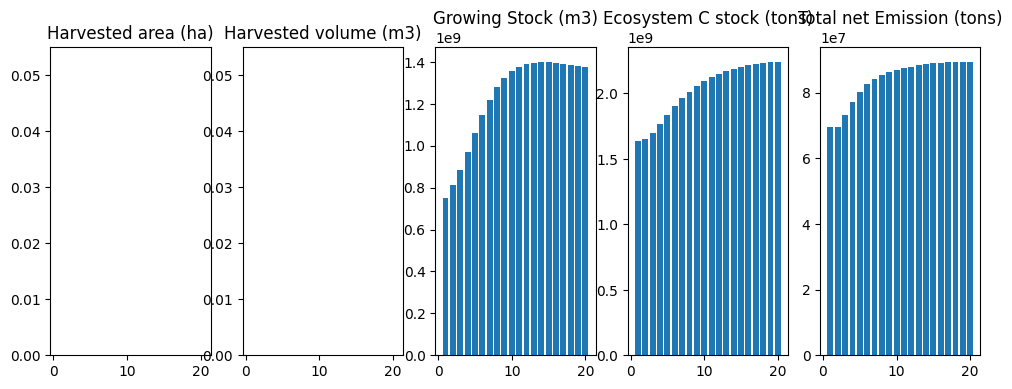

In [48]:
df = compile_scenario(fm)
plot_scenario(df)

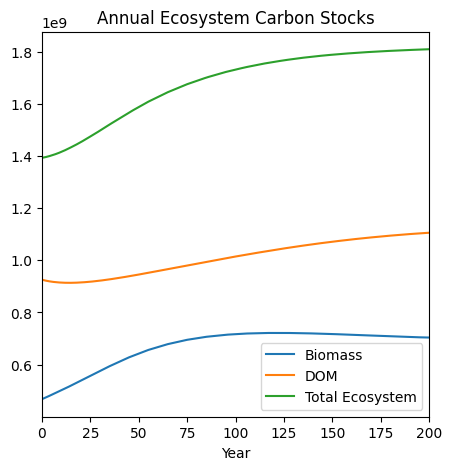

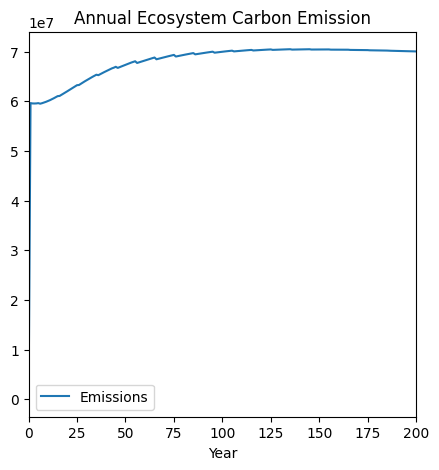

In [49]:
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_pool      dom_pool      eco_pool          flux
 0        1  4.825206e+08  1.163107e+09  1.633098e+09  6.958177e+07
 1        2  5.316346e+08  1.131466e+09  1.651482e+09  6.965194e+07
 2        3  5.891225e+08  1.121660e+09  1.700252e+09  7.312155e+07
 3        4  6.511187e+08  1.123446e+09  1.765515e+09  7.710407e+07
 4        5  7.121326e+08  1.131577e+09  1.836401e+09  8.033652e+07
 5        6  7.669597e+08  1.142905e+09  1.904076e+09  8.260130e+07
 6        7  8.125760e+08  1.155493e+09  1.964025e+09  8.414995e+07
 7        8  8.487899e+08  1.168245e+09  2.014969e+09  8.528386e+07
 8        9  8.767276e+08  1.180770e+09  2.057453e+09  8.615983e+07
 9       10  8.980034e+08  1.192974e+09  2.092708e+09  8.687644e+07
 10      11  9.142454e+08  1.204844e+09  2.122276e+09  8.746841e+07
 11      12  9.268013e+08  1.216202e+09  2.147179e+09  8.797747e+07
 12      13  9.366849e+08  1.226995e+09  2.168283e+09  8.839845e+07
 13      14  9.444127e+08  1.237422e+09  2.18636

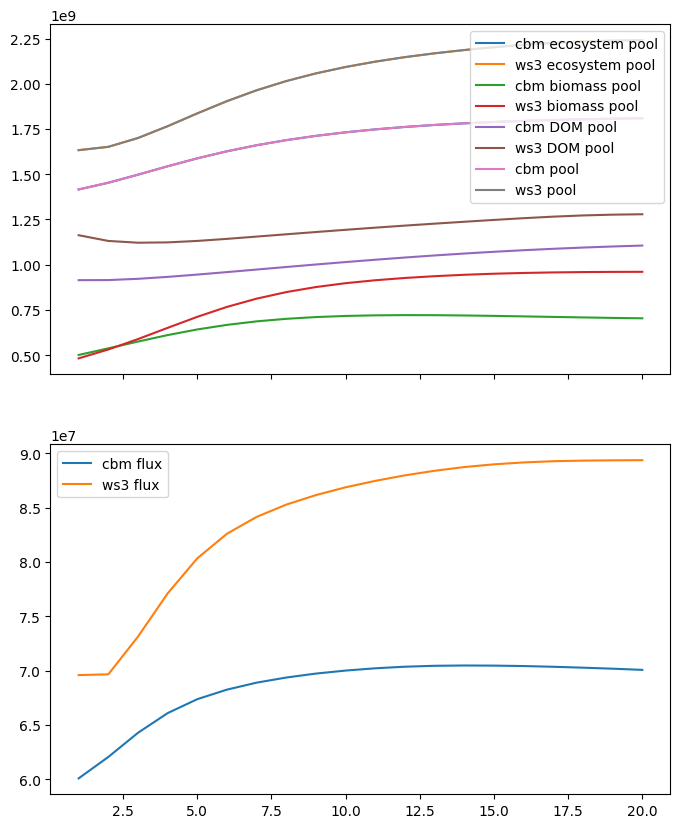

In [50]:
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

Looks good when there is no harvest!

Simulate some harvesting in all periods

In [51]:
fm.reset()
from util import schedule_harvest_areacontrol, compile_scenario, plot_scenario
sch = schedule_harvest_areacontrol(fm)

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total net Emission (tons)'}>],
       dtype=object))

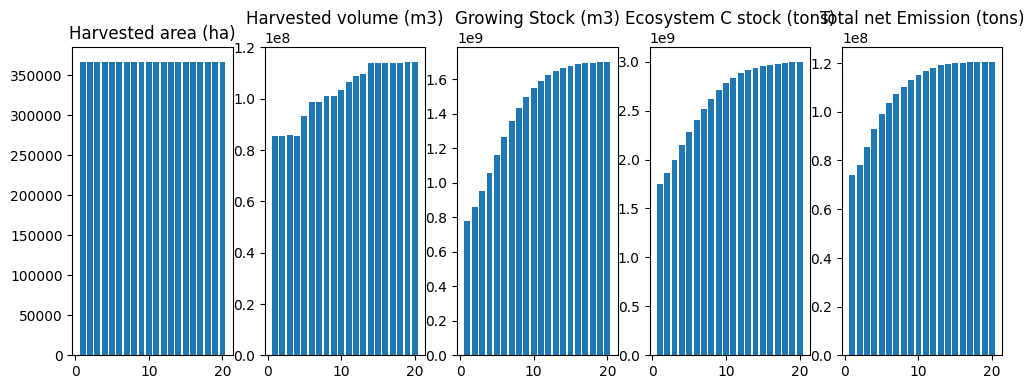

In [52]:
df = compile_scenario(fm)
plot_scenario(df)

In [53]:
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [54]:
from util import complie_events

In [55]:
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [56]:
sit_tables['sit_events'] = sit_events

In [57]:
sit_events = sit_events.drop_duplicates(ignore_index=True)

In [58]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,105.100000,harvest,10
1,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,52.100000,harvest,10
2,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,9.600000,harvest,10
3,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,59.900000,harvest,10
4,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,38.700000,harvest,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,tsa24,1,2403003,304,2423003,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,17194.113452,harvest,200
713,tsa24,1,2402002,204,2422002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,43248.666014,harvest,200
714,tsa24,1,2401002,204,2421002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,36264.609032,harvest,200
715,tsa24,1,2403007,100,2423007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,8788.260776,harvest,200


In [59]:
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

(    period  biomass_pool      dom_pool      eco_pool          flux
 0        1  5.369439e+08  1.220426e+09  1.745693e+09  7.409946e+07
 1        2  6.337981e+08  1.238362e+09  1.862289e+09  7.825095e+07
 2        3  7.343397e+08  1.273520e+09  1.999872e+09  8.545022e+07
 3        4  8.376054e+08  1.318632e+09  2.150382e+09  9.301738e+07
 4        5  9.301483e+08  1.359586e+09  2.285808e+09  9.893020e+07
 5        6  1.011491e+09  1.398308e+09  2.407297e+09  1.034112e+08
 6        7  1.083440e+09  1.438261e+09  2.520755e+09  1.071613e+08
 7        8  1.143538e+09  1.476097e+09  2.620308e+09  1.102875e+08
 8        9  1.194347e+09  1.512677e+09  2.709329e+09  1.130721e+08
 9       10  1.233708e+09  1.543803e+09  2.781077e+09  1.152314e+08
 10      11  1.263076e+09  1.569558e+09  2.837135e+09  1.168520e+08
 11      12  1.284833e+09  1.590587e+09  2.880477e+09  1.180679e+08
 12      13  1.301789e+09  1.608533e+09  2.915567e+09  1.190548e+08
 13      14  1.310780e+09  1.620405e+09  2.93622

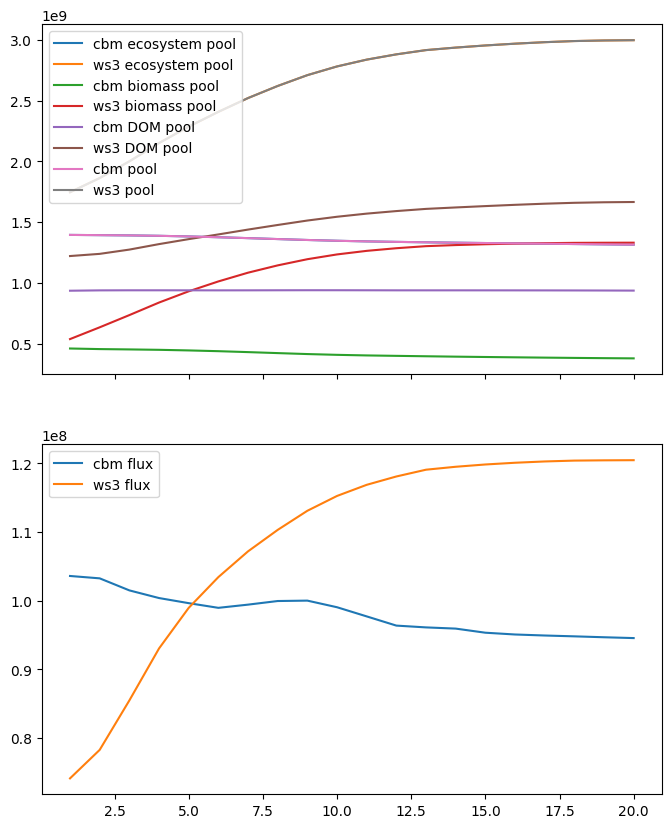

In [60]:
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

## Implement optimization-based action scheduling

In [61]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [62]:
import gurobipy as grb

Import functions

In [63]:
from util import cmp_c_z,cmp_c_cflw,cmp_c_caa,cmp_c_ci, gen_scenario 

Add a "null" action to the model for the optimization functions to work correctly.

In [64]:
fm.add_null_action()

Define base and other scenarios below

In [65]:
def run_scenario(fm, scenario_name='base'):
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    cgen_cp = {}
    cgen_cf = {}
    
    # define harvest area and harvest volume flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)
    
    in_gs = 750290200. #initial growing stock volume
    in_cp = 1319073591.63 #initial total ecosystem carbon stock
    in_cf = 20034534.75 #intial total ecosystem carbon emission
    AAC = 7031963. # AAC of TSA24

    if scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
        cgen_gs = {'lb':{1:0}, 'ub':{1:9999999999}} 
        cgen_hv = {'lb':{1:0}, 'ub':{1:9999999999}}    
    elif scenario_name == 'base_h': 
        # Base scenario
        print('running base scenario')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC-1}, 'ub':{1:AAC}}
    elif scenario_name == 'base_c': 
        # Cabron indicators constraints
        print('running base scenario with carbon constraints')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC-1}, 'ub':{1:AAC}}   
        cgen_cp = {'lb':{10:in_cp*0.9}, 'ub':{10:in_cp*0.9+1}} #Not less than 90% of initial total ecosystem carbon stock
        cgen_cf = {'lb':{10:in_cf}, 'ub':{10:in_cf*1.1}} #Not more than 110% of initial total ecosystem carbon stock
    elif scenario_name == 'reduce_10%_AAC': 
        # Reduce 10% of harvest volume from base scenario
        print('running base scenario reduced 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}}#Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.9-1}, 'ub':{1:AAC*0.9}}    
    elif scenario_name == 'reduce_20%_AAC': 
        # Reduce 20% of harvest volume from base scenario
        print('running base scenario reduced 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.8-1}, 'ub':{1:AAC*0.8}}   
    elif scenario_name == 'increase_10%_AAC': 
        # Increase 10% of harvest volume from base scenario
        print('running base scenario increased 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.1-1}, 'ub':{1:AAC*1.1}}
    elif scenario_name == 'increase_20%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.2-1}, 'ub':{1:AAC*1.2}}
    elif scenario_name == 'increase_50%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 50% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.5-1}, 'ub':{1:AAC*1.5}}
    elif scenario_name == 'increase_100%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 100% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.2-1}, 'ub':{1:AAC*1.2}}
    elif scenario_name == 'increase_500%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 500% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*2-1}, 'ub':{1:AAC*2}}
    elif scenario_name == 'increase_1000%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 1000% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*10-1}, 'ub':{1:AAC*10}}
    elif scenario_name == 'increase_5000%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 5000% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*50-1}, 'ub':{1:AAC*50}}
    elif scenario_name == 'increase_10000%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 10000% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*100-1}, 'ub':{1:AAC*100}}    
    else:
        assert False # bad scenario name
      
    # p = gen_scenario(fm=fm, 
    #                  name=scenario_name, 
    #                  cflw_ha=cflw_ha, 
    #                  cflw_hv=cflw_hv,
    #                  cgen_ha=cgen_ha,
    #                  cgen_hv=cgen_hv,
    #                  cgen_gs=cgen_gs)
    
    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs,
                     cgen_cp=cgen_cp,
                     cgen_cf=cgen_cf)

    fm.reset()
    m = p.solve()

    if m.status != grb.GRB.OPTIMAL:
        print('Model not optimal.')
        sys.exit()
        
    sch = fm.compile_schedule(p)
    fm.apply_schedule(sch, 
                      force_integral_area=False, 
                      override_operability=False,
                      fuzzy_age=False,
                      recourse_enabled=False,
                      verbose=False,
                      compile_c_ycomps=True)
    
    from util import compile_scenario, plot_scenario
    df = compile_scenario(fm)
    fig, ax = plot_scenario(df)
    # cbm_results = cbm_hardlink(fm,disturbance_type_mapping)
    
    return fig, df, p

In [66]:
%load_ext memory_profiler

In [67]:
from util import run_scenario

In [ ]:
%mprun -f run_scenario run_scenario(fm,'base') # Maximize Carbon Stock

running base scenario


In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

In [ ]:
run_scenario(fm,'base') # Maximize Carbon Stock

There some development types without carbon yield curves. So plug the C curves into them again.

In [ ]:
plugin_c_curves(fm, c_curves_p, c_curves_f, pools=pools+sum_pools, fluxes=fluxes+sum_fluxes)

In [ ]:
run_scenario(fm,'base') # Maximize Carbon Stock

In [ ]:
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
sit_tables['sit_events'] = sit_events

In [ ]:
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

In [ ]:
# run_scenario(fm,'base_h') # Maximize Carbon Stock with Havest Volume & Area Constraints

In [ ]:
# run_scenario(fm,'base_h') # Maximize Carbon Stock with Havest Volume & Area Constraints with Havest Volume & Area Constraints

In [ ]:
# run_scenario(fm,'base_c') # Maximize Carbon Stocks with Havest Volume & Area Constraints and Carbon Pools & Fluxes Constraints

In [ ]:
#run_scenario(fm,'base') # Maximize Havest Volume without Havest Volume & Area Constraints

In [ ]:
#run_scenario(fm,'base_h') # Maximize Havest Volume with Havest Volume & Area Constraints

In [ ]:
#run_scenario(fm,'base_c') # Maximize Havest Volume with Havest Volume & Area Constraints and Carbon Pools & Fluxes Constraints

In [ ]:
#run_scenario(fm,'reduce_10%_AAC')

In [ ]:
#run_scenario(fm,'reduce_20%_AAC')

In [ ]:
#run_scenario(fm,'increase_20%_AAC')

In [ ]:
#run_scenario(fm,'increase_20%_AAC')